## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from tqdm import tqdm_notebook as tqdm

## Import Files

In [113]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [114]:
submission = pd.read_csv('./sample_submission.csv')

In [115]:
backup_train = train
backup_test = test

In [116]:
def reset_data():
    train = backup_train
    test = backup_test

## Do Data Analysis

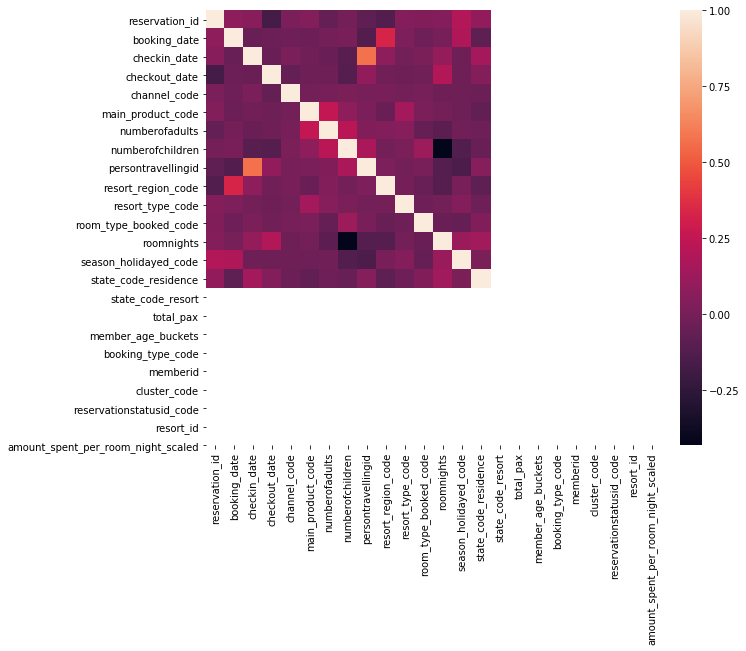

In [54]:
plt.subplots(figsize=(10,8))
ax = plt.axes()
sns.heatmap(train.corr(), 
            xticklabels=train.columns.values,
            yticklabels=train.columns.values)

In [55]:
train.corr().to_csv('./correlation.csv')

## Mean Encode Items

### Define Label Encoder

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [118]:
def label_encode_item(df, colname):
    current_col = df[colname]
    df[colname] = le.fit_transform(current_col)
    return df

### Define Mean Encoder

In [119]:
def mean_encode_items(df, colname, target):
    unique_vals = df[colname].unique()
    overall_sum = df[target].sum()
    for val in unique_vals:
        sum_of_val = df.loc[df[colname] == val][target].sum()
        ratio = float(sum_of_val) / overall_sum
        indices_under_val = df.loc[df[colname] == val].index
        df.at[indices_under_val, colname] = ratio
        tranfer_weights_to_test(val, colname, ratio)
    return df

## Get Duration of Stay

In [120]:
def get_duration(df, col_after, col_before):
    return (pd.to_datetime(df[col_after], dayfirst=True) - 
            pd.to_datetime(df[col_before], dayfirst=True)).astype(int)

In [121]:
def get_days(value):
    return value.split(' ')[0]

In [122]:
train['length_from_stay'] = get_duration(train, 
                                         'checkin_date', 
                                         'booking_date')
train['duration'] = get_duration(train, 
                                   'checkout_date', 
                                   'checkin_date')

## Get Total Pax

In [62]:
train['total_pax'] = train['numberofadults'] + train['numberofchildren']

### Execute Mean Encoding

In [124]:
item_to_mean_encode = ['member_age_buckets',
                       'memberid',
                       'cluster_code', 
                       'reservationstatusid_code', 
                       'resort_id', 
                       ]

In [125]:
for item in tqdm(item_to_mean_encode):
    train = label_encode_item(train, item)

In [126]:
train['season_holidayed_code'] = train['season_holidayed_code'].fillna(train['season_holidayed_code'].median())

In [127]:
train['state_code_residence'] = train['state_code_residence'].fillna(train['state_code_residence'].median())

## Clean Columns

In [128]:
columns_to_drop = ['reservation_id',
                   'booking_date',
                   'checkin_date', 
                   'checkout_date']

In [129]:
def clean_data_set(df):
    for colname in columns_to_drop:
        df = df.drop(colname, axis = 1)
    return df

In [130]:
train = clean_data_set(train)

## Get X and y

In [131]:
train_y = train['amount_spent_per_room_night_scaled']
train_X = train.drop('amount_spent_per_room_night_scaled', axis=1)

## Process Test Data

In [133]:
test['length_from_stay'] = get_duration(test, 
                                        'checkin_date', 
                                        'booking_date')
test['duration'] = get_duration(test, 
                                  'checkout_date', 
                                  'checkin_date')
test['total_pax'] = test['numberofadults'] + test['numberofchildren']
for item in tqdm(item_to_mean_encode):
    test = label_encode_item(test, item)
test = clean_data_set(test)

In [134]:
test['season_holidayed_code'] = test['season_holidayed_code'].fillna(test['season_holidayed_code'].median())
test['state_code_residence'] = test['state_code_residence'].fillna(test['state_code_residence'].median())

## Perform Cross Validation

In [72]:
from scipy.stats import rankdata
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

In [73]:
log_reg_model = LogisticRegression(solver='liblinear', verbose=1)

In [74]:
train['is_test'] = 0
test['is_test'] = 1

In [75]:
train_examples = train.shape[0]
train_y = train['amount_spent_per_room_night_scaled']
new_train = train.drop('amount_spent_per_room_night_scaled', axis=1)
combined_data = pd.concat([test, new_train], axis=0).reset_index(drop=True)

In [76]:
combined_data_X = combined_data.drop('is_test', axis=1)
combined_data_y = combined_data['is_test']

In [77]:
is_test_probs = cross_val_predict(log_reg_model, 
                                  combined_data_X, 
                                  combined_data_y, 
                                  method='predict_proba',
                                  cv = 10
                                 )

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [78]:
cut_length = is_test_probs[0:train_examples,:-1]
new_train['is_test'] = rankdata(cut_length)

## Test LightGBM

In [79]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [149]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.35)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

In [150]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 500,
    'max_depth': 1000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'num_threads' : 2,
    'max_bin': 255,
    'verbose': 0
}

In [151]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval, 
                early_stopping_rounds=100)

[1]	valid_0's rmse: 1.08083
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.07913
[3]	valid_0's rmse: 1.07802
[4]	valid_0's rmse: 1.07642
[5]	valid_0's rmse: 1.07551
[6]	valid_0's rmse: 1.0739
[7]	valid_0's rmse: 1.0729
[8]	valid_0's rmse: 1.07188
[9]	valid_0's rmse: 1.0704
[10]	valid_0's rmse: 1.06896
[11]	valid_0's rmse: 1.06763
[12]	valid_0's rmse: 1.0662
[13]	valid_0's rmse: 1.06484
[14]	valid_0's rmse: 1.0639
[15]	valid_0's rmse: 1.06264
[16]	valid_0's rmse: 1.06129
[17]	valid_0's rmse: 1.06007
[18]	valid_0's rmse: 1.05921
[19]	valid_0's rmse: 1.05787
[20]	valid_0's rmse: 1.05665
[21]	valid_0's rmse: 1.05536
[22]	valid_0's rmse: 1.05422
[23]	valid_0's rmse: 1.05347
[24]	valid_0's rmse: 1.05233
[25]	valid_0's rmse: 1.05123
[26]	valid_0's rmse: 1.05011
[27]	valid_0's rmse: 1.04933
[28]	valid_0's rmse: 1.04833
[29]	valid_0's rmse: 1.04761
[30]	valid_0's rmse: 1.04701
[31]	valid_0's rmse: 1.04588
[32]	valid_0's rmse: 1.04482
[33]	valid_0's rmse: 1.

[278]	valid_0's rmse: 0.980279
[279]	valid_0's rmse: 0.980235
[280]	valid_0's rmse: 0.980195
[281]	valid_0's rmse: 0.980156
[282]	valid_0's rmse: 0.980125
[283]	valid_0's rmse: 0.980089
[284]	valid_0's rmse: 0.980051
[285]	valid_0's rmse: 0.98
[286]	valid_0's rmse: 0.979951
[287]	valid_0's rmse: 0.979921
[288]	valid_0's rmse: 0.979887
[289]	valid_0's rmse: 0.979844
[290]	valid_0's rmse: 0.979808
[291]	valid_0's rmse: 0.979759
[292]	valid_0's rmse: 0.97973
[293]	valid_0's rmse: 0.979687
[294]	valid_0's rmse: 0.979651
[295]	valid_0's rmse: 0.979614
[296]	valid_0's rmse: 0.979587
[297]	valid_0's rmse: 0.979557
[298]	valid_0's rmse: 0.979528
[299]	valid_0's rmse: 0.979506
[300]	valid_0's rmse: 0.979466
[301]	valid_0's rmse: 0.979433
[302]	valid_0's rmse: 0.979396
[303]	valid_0's rmse: 0.979364
[304]	valid_0's rmse: 0.979327
[305]	valid_0's rmse: 0.979294
[306]	valid_0's rmse: 0.979271
[307]	valid_0's rmse: 0.979244
[308]	valid_0's rmse: 0.979218
[309]	valid_0's rmse: 0.979193
[310]	valid_0

[547]	valid_0's rmse: 0.976355
[548]	valid_0's rmse: 0.976346
[549]	valid_0's rmse: 0.976342
[550]	valid_0's rmse: 0.976339
[551]	valid_0's rmse: 0.976333
[552]	valid_0's rmse: 0.97633
[553]	valid_0's rmse: 0.97633
[554]	valid_0's rmse: 0.976338
[555]	valid_0's rmse: 0.976337
[556]	valid_0's rmse: 0.976336
[557]	valid_0's rmse: 0.976329
[558]	valid_0's rmse: 0.976326
[559]	valid_0's rmse: 0.976325
[560]	valid_0's rmse: 0.976317
[561]	valid_0's rmse: 0.976304
[562]	valid_0's rmse: 0.976308
[563]	valid_0's rmse: 0.976303
[564]	valid_0's rmse: 0.976306
[565]	valid_0's rmse: 0.97631
[566]	valid_0's rmse: 0.976309
[567]	valid_0's rmse: 0.976304
[568]	valid_0's rmse: 0.976305
[569]	valid_0's rmse: 0.976302
[570]	valid_0's rmse: 0.976312
[571]	valid_0's rmse: 0.976298
[572]	valid_0's rmse: 0.976289
[573]	valid_0's rmse: 0.976278
[574]	valid_0's rmse: 0.976269
[575]	valid_0's rmse: 0.976255
[576]	valid_0's rmse: 0.976252
[577]	valid_0's rmse: 0.976251
[578]	valid_0's rmse: 0.976249
[579]	valid

In [153]:
y_pred = gbm.predict(test, num_iteration=gbm.best_iteration)

In [154]:
submission['amount_spent_per_room_night_scaled'] = y_pred

In [155]:
submission.to_csv('./Submissions/Test12.csv', index=False)

## Test CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

## Test SGD Regressor

In [ ]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(max_iter=1000, tol=1e-3)

In [ ]:
model.fit(train_X, train_y)

## Test XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
param = {'max_depth':2, 
         'eta':1, 
         'silent':1, 
         'objective':'reg:squarederror'}
watchlist = [(test, 'eval'), (train, 'train')]

In [ ]:

# specify validations set to watch performance

num_round = 2
bst = xgb.train(param, train, num_round, watchlist)


In [ ]:
# model_xgb = xgb.XGBRegressor(max_depth=500)
xgb.train(params, train_X, train_y)

In [ ]:
submission['amount_spent_per_room_night_scaled'] = model_xgb.predict(test)

In [ ]:
submission.to_csv('./Submissions/Test2.csv', index=False)